In [5]:
import datetime as dt
import sys
import numpy as np
from numpy import cumsum, log, polyfit, sqrt, std, subtract
from numpy.random import randn
import pandas as pd
# from pandas_datareader import data as web  # Commented out if not used
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from arch import arch_model
from numpy.linalg import LinAlgError
from scipy import stats
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from sklearn.metrics import mean_squared_error
from scipy.stats import probplot, moment
from arch.univariate import ConstantMean, GARCH, Normal
from sklearn.model_selection import TimeSeriesSplit
from datasets import load_dataset
from tqdm import tqdm
import os
from pathlib import Path
import warnings

# Add the parent directory of the notebook to the Python path
sys.path.append(str(Path().resolve().parent))
sys.path.append(str(Path().resolve().parent.parent))

# Custom module imports
from funcs.data_read import (
    read_txn_data,
    read_ob_data,
    load_ob_features,
    load_trx_features,
)

from funcs.preprocess import (
    preprocess_ob_data,
    preprocess_trx_data,
)

from funcs.features import (
    create_features_order_book,
    create_features_trx,
)

from funcs.utils import (
    filter_extremes,
    deseason_total_volume,
)

# Optional: Suppress warnings if desired
warnings.filterwarnings('ignore')  # Uncomment if you want to suppress warnings

In [6]:
trx_1min_features = load_trx_features("1min")
ob_1min_features=load_ob_features(freq="1min")
ob_1min_features_dec = deseason_total_volume(trx_1min_features)

 
# Ensure both DataFrames have the same timestamp format
#trx_1min_features['timestamp_id'] = pd.to_datetime(trx_1min_features['timestamp_id'])
#ob_1min_features['timestamp_id'] = pd.to_datetime(ob_1min_features['timestamp_id'])

merged_features = pd.merge_asof(
    trx_1min_features.sort_values("timestamp_id"),
    ob_1min_features_dec.sort_values("timestamp_id"),
    on="timestamp_id",
    #direction="nearest",
    #tolerance=pd.Timedelta("2min"),
    suffixes=('_trx', '_ob')  # Avoid adding _x or _y suffixes
)

✅ Loaded TRX features (1min) from:
c:\Users\peter\codes\ml\eth\Komplex\trx_features\trx_features_1min.parquet
Reading 109 files from c:\Users\peter\codes\ml\eth\Komplex\ob_features\1min...
Combined DataFrame for 1min created. Total rows: 155,954
Deseasoned total volume column added successfully.


### AGAIN the merge is not correct as we work with smaller frames - times are not maching

#### Log Transform

In [7]:
merged_features['log_deseasoned_total_volume'] = np.log(merged_features['deseasoned_total_volume'] + 1e-07)
merged_features = merged_features.dropna()

In [8]:
merged_features

,timestamp_id,datetime_trx,first_price_trx,last_price_trx,max_price_trx,min_price_trx,buy_volume_trx,sell_volume_trx,total_volume_trx,volume_imbalance_trx,...,min_price_ob,buy_volume_ob,sell_volume_ob,total_volume_ob,volume_imbalance_ob,buy_transactions_ob,sell_transactions_ob,transaction_imbalance_ob,deseasoned_total_volume,log_deseasoned_total_volume
0,1527800400,2018-05-31 21:00:00+00:00,7538.34,7542.01,7544.79,7531.36,18.203291,0.677437,18.880728,17.525854,...,7531.36,18.203291,0.677437,18.880728,17.525854,12.0,11.0,1.0,9.587523,2.260463
14,1527801240,2018-05-31 21:14:00+00:00,7548.97,7536.08,7548.97,7530.89,15.023701,15.688020,30.711721,-0.664319,...,7530.89,15.023701,15.688020,30.711721,-0.664319,13.0,12.0,1.0,18.836753,2.935810
15,1527801300,2018-05-31 21:15:00+00:00,7540.84,7531.61,7541.27,7530.45,14.046733,17.089962,31.136696,-3.043229,...,7530.45,14.046733,17.089962,31.136696,-3.043229,14.0,7.0,7.0,21.319807,3.059637
16,1527801360,2018-05-31 21:16:00+00:00,7542.59,7535.28,7542.59,7531.92,7.450610,3.773471,11.224081,3.677139,...,7531.92,7.450610,3.773471,11.224081,3.677139,11.0,4.0,7.0,2.104191,0.743931
19,1527801540,2018-05-31 21:19:00+00:00,7540.50,7541.98,7541.98,7540.50,0.899537,7.379292,8.278829,-6.479756,...,7540.50,0.899537,7.379292,8.278829,-6.479756,5.0,2.0,3.0,0.160288,-1.830783
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168681,1538340720,2018-09-30 20:52:00+00:00,6536.43,6536.43,6540.01,6536.43,4.429798,2.149343,6.579141,2.280455,...,6536.43,4.429798,2.149343,6.579141,2.280455,7.0,6.0,1.0,0.301541,-1.198848
168693,1538341440,2018-09-30 21:04:00+00:00,6551.78,6558.94,6560.00,6551.71,26.720565,0.422674,27.143239,26.297891,...,6551.71,26.720565,0.422674,27.143239,26.297891,16.0,4.0,12.0,14.762414,2.692084
168695,1538341560,2018-09-30 21:06:00+00:00,6562.99,6565.97,6566.02,6562.77,4.326039,12.952368,17.278407,-8.626328,...,6562.77,4.326039,12.952368,17.278407,-8.626328,32.0,13.0,19.0,6.116597,1.811006
168721,1538343300,2018-09-30 21:35:00+00:00,6544.96,6544.96,6545.00,6544.96,8.965864,0.000000,8.965864,8.965864,...,6544.96,8.965864,0.000000,8.965864,8.965864,12.0,0.0,12.0,0.324590,-1.125194


### Lag and drop temporary variables

In [9]:
# drop desesoned_total_volume and lag everything but log_deseasoned_total_volume
merged_features = merged_features.drop(columns=['deseasoned_total_volume'])
#everything but log_deseasoned_total_volume is lagged by 1
for col in merged_features.columns:
    if col != 'log_deseasoned_total_volume':
        merged_features[col] = merged_features[col].shift(1)
# drop NaN values
merged_features = merged_features.dropna()

- We use the first $70 \%$ of points for training, the next $10 \%$ for validation, and the last $20 \%$ of points for out-of-sample testing.

GBM is the gradient boosting machine [60]. It has been empirically proven to be highly effective in predictive tasks across different machine learning challenges $[61,62]$ and more recently in finance [63,64]. The feature vector fed into GBM is also the concatenation of features from order book and transaction data of two markets. The hyper-parameters [65] of GBM are selected by random search in the ranges: number of trees in $[100, \cdots, 1000]$, max number of features used by individual trees in $[1.0, \cdots, 0.1]$, minimum number of samples of the leaf nodes in $[2, \cdots, 9]$, maximum depth of individual trees in $[4, \cdots, 9]$, and the learning rate in $[0.05, \cdots, 0.005]$.

In [10]:
merged_features

,timestamp_id,datetime_trx,first_price_trx,last_price_trx,max_price_trx,min_price_trx,buy_volume_trx,sell_volume_trx,total_volume_trx,volume_imbalance_trx,...,max_price_ob,min_price_ob,buy_volume_ob,sell_volume_ob,total_volume_ob,volume_imbalance_ob,buy_transactions_ob,sell_transactions_ob,transaction_imbalance_ob,log_deseasoned_total_volume
14,1.527800e+09,2018-05-31 21:00:00+00:00,7538.34,7542.01,7544.79,7531.36,18.203291,0.677437,18.880728,17.525854,...,7544.79,7531.36,18.203291,0.677437,18.880728,17.525854,12.0,11.0,1.0,2.935810
15,1.527801e+09,2018-05-31 21:14:00+00:00,7548.97,7536.08,7548.97,7530.89,15.023701,15.688020,30.711721,-0.664319,...,7548.97,7530.89,15.023701,15.688020,30.711721,-0.664319,13.0,12.0,1.0,3.059637
16,1.527801e+09,2018-05-31 21:15:00+00:00,7540.84,7531.61,7541.27,7530.45,14.046733,17.089962,31.136696,-3.043229,...,7541.27,7530.45,14.046733,17.089962,31.136696,-3.043229,14.0,7.0,7.0,0.743931
19,1.527801e+09,2018-05-31 21:16:00+00:00,7542.59,7535.28,7542.59,7531.92,7.450610,3.773471,11.224081,3.677139,...,7542.59,7531.92,7.450610,3.773471,11.224081,3.677139,11.0,4.0,7.0,-1.830783
24,1.527802e+09,2018-05-31 21:19:00+00:00,7540.50,7541.98,7541.98,7540.50,0.899537,7.379292,8.278829,-6.479756,...,7541.98,7540.50,0.899537,7.379292,8.278829,-6.479756,5.0,2.0,3.0,2.078207
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168681,1.538340e+09,2018-09-30 20:42:00+00:00,6541.45,6550.12,6550.13,6541.45,6.101551,0.200179,6.301730,5.901372,...,6550.13,6541.45,6.101551,0.200179,6.301730,5.901372,12.0,2.0,10.0,-1.198848
168693,1.538341e+09,2018-09-30 20:52:00+00:00,6536.43,6536.43,6540.01,6536.43,4.429798,2.149343,6.579141,2.280455,...,6540.01,6536.43,4.429798,2.149343,6.579141,2.280455,7.0,6.0,1.0,2.692084
168695,1.538341e+09,2018-09-30 21:04:00+00:00,6551.78,6558.94,6560.00,6551.71,26.720565,0.422674,27.143239,26.297891,...,6560.00,6551.71,26.720565,0.422674,27.143239,26.297891,16.0,4.0,12.0,1.811006
168721,1.538342e+09,2018-09-30 21:06:00+00:00,6562.99,6565.97,6566.02,6562.77,4.326039,12.952368,17.278407,-8.626328,...,6566.02,6562.77,4.326039,12.952368,17.278407,-8.626328,32.0,13.0,19.0,-1.125194


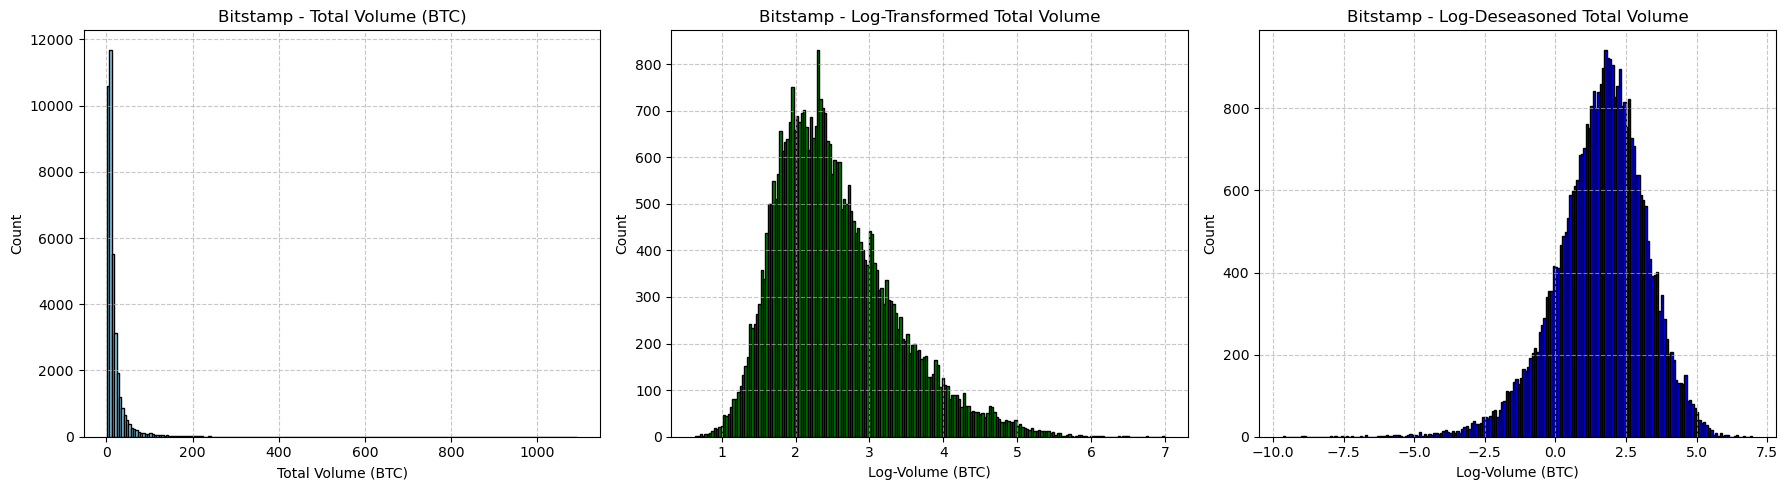

In [17]:
total_volume= merged_features['total_volume_trx']
# Histogram of the total_volume
log_volume_deseasoned = merged_features['log_deseasoned_total_volume']

# Calculate log of total_volume_trx with a small constant to handle zeros
small_constant = 1e-10  # Small number to avoid log(0)
log_volume_raw = np.log(total_volume + small_constant)

# Create a figure with three subplots side by side
plt.figure(figsize=(18, 5))

# Plot 1: Histogram of total_volume_trx
plt.subplot(1, 3, 1)
plt.hist(total_volume, bins=200, color='skyblue', edgecolor='black')
plt.title('Bitstamp - Total Volume (BTC)', fontsize=12)
plt.xlabel('Total Volume (BTC)', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)

# Plot 2: Histogram of log-transformed total_volume_trx
plt.subplot(1, 3, 2)
plt.hist(log_volume_raw, bins=200, color='green', edgecolor='black')
plt.title('Bitstamp - Log-Transformed Total Volume', fontsize=12)
plt.xlabel('Log-Volume (BTC)', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)

# Plot 3: Histogram of log_deseasoned_total_volume
plt.subplot(1, 3, 3)
plt.hist(log_volume_deseasoned, bins=200, color='blue', edgecolor='black')
plt.title('Bitstamp - Log-Deseasoned Total Volume', fontsize=12)
plt.xlabel('Log-Volume (BTC)', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


In [11]:
# cut the first 10k entries

merged_features = merged_features.iloc[400:]

DataFrame shape: (38498, 26)
Columns: Index(['timestamp_id', 'datetime_trx', 'first_price_trx', 'last_price_trx',
       'max_price_trx', 'min_price_trx', 'buy_volume_trx', 'sell_volume_trx',
       'total_volume_trx', 'volume_imbalance_trx', 'buy_transactions_trx',
       'sell_transactions_trx', 'transaction_imbalance_trx', 'datetime_ob',
       'first_price_ob', 'last_price_ob', 'max_price_ob', 'min_price_ob',
       'buy_volume_ob', 'sell_volume_ob', 'total_volume_ob',
       'volume_imbalance_ob', 'buy_transactions_ob', 'sell_transactions_ob',
       'transaction_imbalance_ob', 'log_deseasoned_total_volume'],
      dtype='object')
NaN count in log_deseasoned_total_volume: 0
Cleaned DataFrame shape: (38498, 22)
NaN count after cleaning: 0
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best hyperparameters: {'n_estimators': 200, 'min_samples_leaf': 5, 'max_features': 0.7000000000000001, 'max_depth': 4, 'learning_rate': 0.010000000000000002}
Root Mean Squared Error (RMS

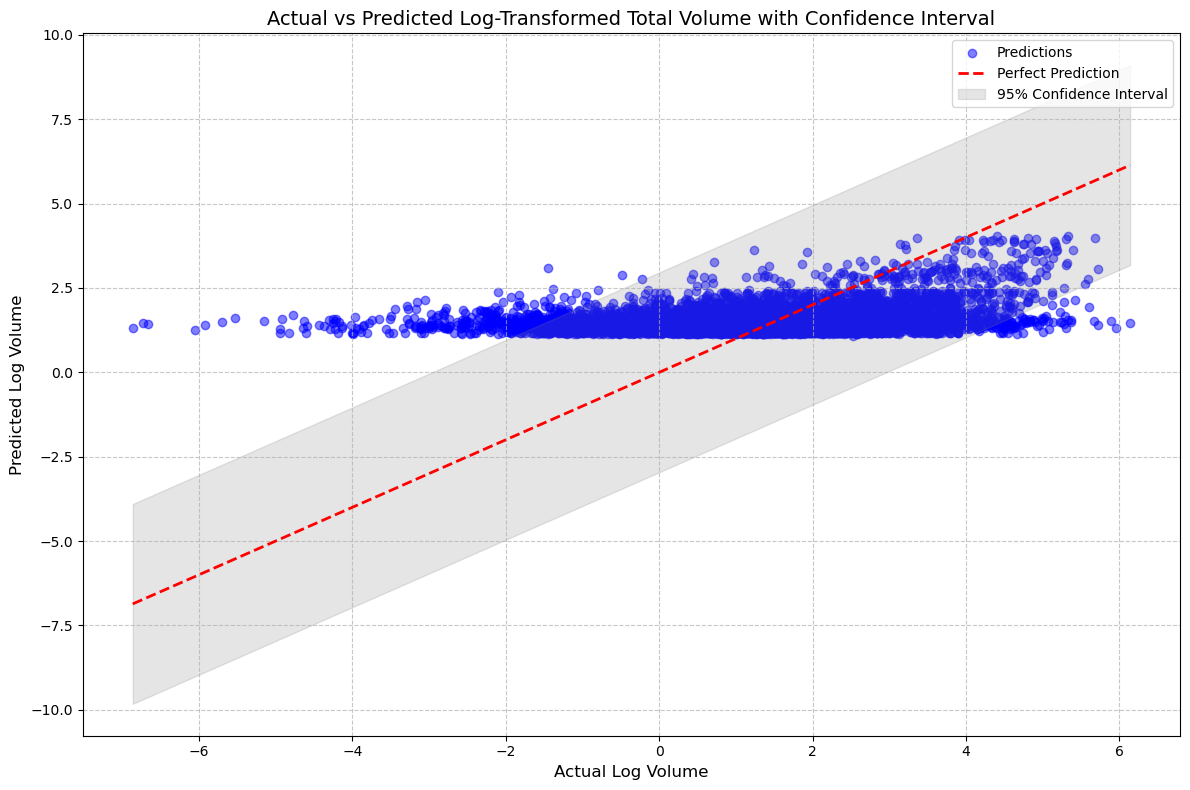

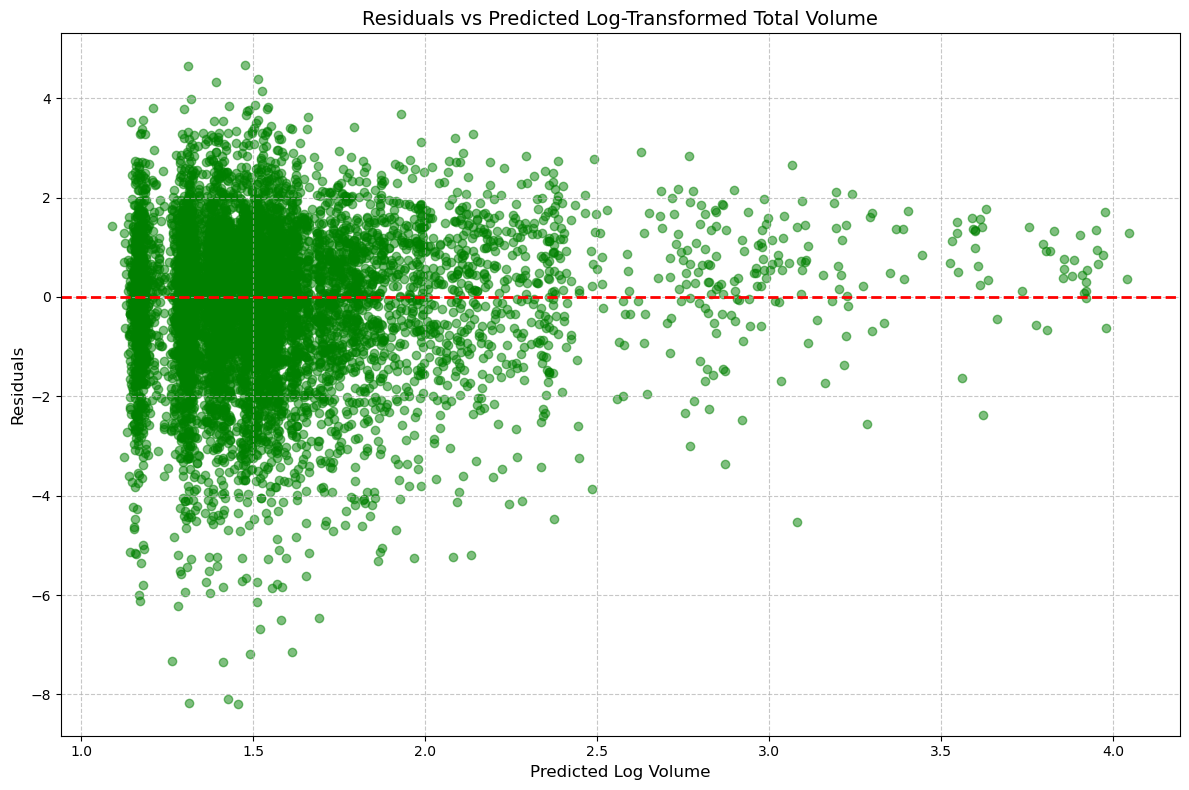

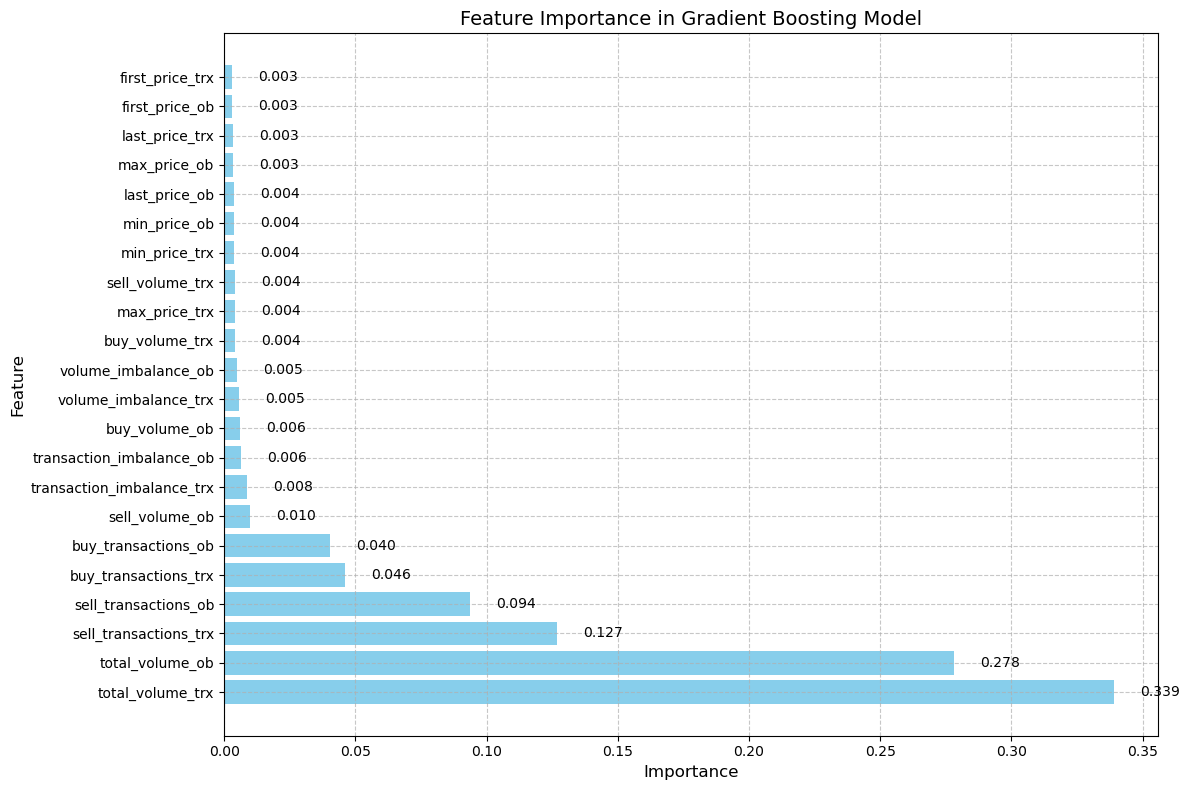

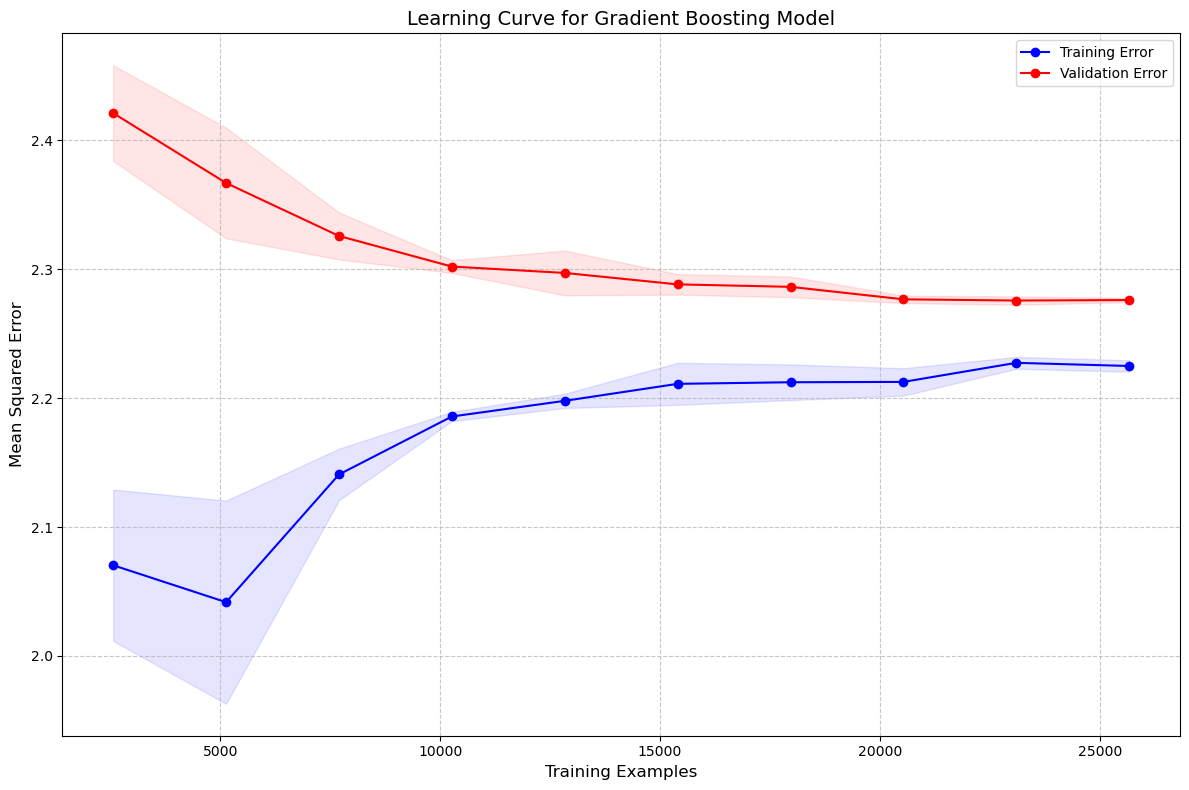

In [14]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from sklearn.model_selection import learning_curve
from scipy.stats import norm

# Assuming merged_features is your DataFrame with the specified columns
print("DataFrame shape:", merged_features.shape)
print("Columns:", merged_features.columns)
print("NaN count in log_deseasoned_total_volume:", merged_features['log_deseasoned_total_volume'].isnull().sum())

# Prepare the target variable (Y) as log_deseasoned_total_volume
Y = merged_features['log_deseasoned_total_volume']

# Prepare the feature matrix (X) by dropping non-feature columns
X = merged_features.drop(columns=['timestamp_id', 'datetime_trx', 'datetime_ob', 'log_deseasoned_total_volume'])

# Ensure all remaining columns are numeric
for col in X.columns:
    if X[col].dtype == 'object' or X[col].dtype.name == 'datetime64[ns]':
        raise ValueError(f"Column {col} contains non-numeric data: {X[col].dtype}")

# Drop any rows with NaN values in X or Y
merged_features_cleaned = merged_features.dropna(subset=X.columns.tolist() + ['log_deseasoned_total_volume'])
X = merged_features_cleaned.drop(columns=['timestamp_id', 'datetime_trx', 'datetime_ob', 'log_deseasoned_total_volume'])
Y = merged_features_cleaned['log_deseasoned_total_volume']

print("Cleaned DataFrame shape:", X.shape)
print("NaN count after cleaning:", X.isnull().sum().sum())

# Split the data based on timestamps (70% train, 10% validation, 20% test)
n_samples = len(merged_features_cleaned)
train_size = int(0.7 * n_samples)  # 70% for training
val_size = int(0.1 * n_samples)    # 10% for validation
test_size = n_samples - train_size - val_size  # 20% for testing

# Sort by datetime (using datetime_trx as the primary timestamp)
merged_features_cleaned = merged_features_cleaned.sort_values('datetime_trx')

# Split into train, validation, and test sets
X_train = X.iloc[:train_size]
Y_train = Y.iloc[:train_size]
X_val = X.iloc[train_size:train_size + val_size]
Y_val = Y.iloc[train_size:train_size + val_size]
X_test = X.iloc[train_size + val_size:]
Y_test = Y.iloc[train_size + val_size:]

# Define the hyperparameter search space
param_dist = {
    'n_estimators': np.arange(100, 1001, 100),  # [100, 200, ..., 1000]
    'max_features': np.linspace(0.1, 1.0, 10),  # [0.1, 0.2, ..., 1.0]
    'min_samples_leaf': np.arange(2, 10),       # [2, 3, ..., 9]
    'max_depth': np.arange(4, 10),              # [4, 5, ..., 9]
    'learning_rate': np.linspace(0.005, 0.05, 10)  # [0.005, 0.008, ..., 0.05]
}

# Initialize the GradientBoostingRegressor
gbm = GradientBoostingRegressor(random_state=42)

# Perform random search with cross-validation
random_search = RandomizedSearchCV(
    gbm, param_distributions=param_dist, n_iter=20, cv=3, scoring='neg_mean_squared_error',
    random_state=42, n_jobs=-1, verbose=1, error_score='raise'
)

# Fit the random search on the training + validation data
random_search.fit(pd.concat([X_train, X_val]), pd.concat([Y_train, Y_val]))

# Get the best model
best_gbm = random_search.best_estimator_
print("Best hyperparameters:", random_search.best_params_)

# Train the best model on the full training set (train + val)
best_gbm.fit(pd.concat([X_train, X_val]), pd.concat([Y_train, Y_val]))

# Predict on the test set
Y_pred = best_gbm.predict(X_test)

# Evaluate the model with additional metrics
rmse = np.sqrt(mean_squared_error(Y_test, Y_pred))
mae = mean_absolute_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)
print(f"Root Mean Squared Error (RMSE) on Test Set: {rmse:.4f}")
print(f"Mean Absolute Error (MAE) on Test Set: {mae:.4f}")
print(f"R-squared Score on Test Set: {r2:.4f}")

# Calculate Negative Log Likelihood (NLL) - Assuming Gaussian residuals
residuals = Y_test - Y_pred
sigma = np.std(residuals)
nll = -np.mean(norm.logpdf(residuals, loc=0, scale=sigma))
print(f"Negative Log Likelihood (NLL) on Test Set: {nll:.4f}")

# Calculate Information Weight (IW) - Custom metric (e.g., weighted RMSE by prediction variance)
# This is a speculative implementation; adjust based on your definition
var_pred = np.var(Y_pred)
iw = rmse * (1 + np.log1p(var_pred))  # Weighted by variance, log-scaled
print(f"Information Weight (IW) on Test Set: {iw:.4f}")

# Fancy Plots (unchanged)
# 1. Enhanced Predicted vs. Actual Plot with Confidence Intervals
plt.figure(figsize=(12, 8))
plt.scatter(Y_test, Y_pred, color='blue', alpha=0.5, label='Predictions')
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'r--', lw=2, label='Perfect Prediction')

residuals = Y_test - Y_pred
std_residuals = np.std(residuals)
confidence_interval = 1.96 * std_residuals  # 95% confidence interval
plt.fill_between([Y_test.min(), Y_test.max()], 
                 [Y_test.min() - confidence_interval, Y_test.max() - confidence_interval],
                 [Y_test.min() + confidence_interval, Y_test.max() + confidence_interval],
                 color='gray', alpha=0.2, label='95% Confidence Interval')

plt.xlabel("Actual Log Volume", fontsize=12)
plt.ylabel("Predicted Log Volume", fontsize=12)
plt.title("Actual vs Predicted Log-Transformed Total Volume with Confidence Interval", fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 2. Residual Plot
plt.figure(figsize=(12, 8))
plt.scatter(Y_pred, residuals, color='green', alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel("Predicted Log Volume", fontsize=12)
plt.ylabel("Residuals", fontsize=12)
plt.title("Residuals vs Predicted Log-Transformed Total Volume", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 3. Feature Importance Plot
feature_importance = best_gbm.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel("Importance", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.title("Feature Importance in Gradient Boosting Model", fontsize=14)
for i, v in enumerate(feature_importance_df['Importance']):
    plt.text(v + 0.01, i, f'{v:.3f}', va='center')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 4. Learning Curve
train_sizes, train_scores, val_scores = learning_curve(
    best_gbm, X, Y, cv=3, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10),
    scoring='neg_mean_squared_error', random_state=42
)

train_mean = -np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = -np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.figure(figsize=(12, 8))
plt.plot(train_sizes, train_mean, label='Training Error', color='blue', marker='o')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.1)
plt.plot(train_sizes, val_mean, label='Validation Error', color='red', marker='o')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, color='red', alpha=0.1)
plt.xlabel("Training Examples", fontsize=12)
plt.ylabel("Mean Squared Error", fontsize=12)
plt.title("Learning Curve for Gradient Boosting Model", fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

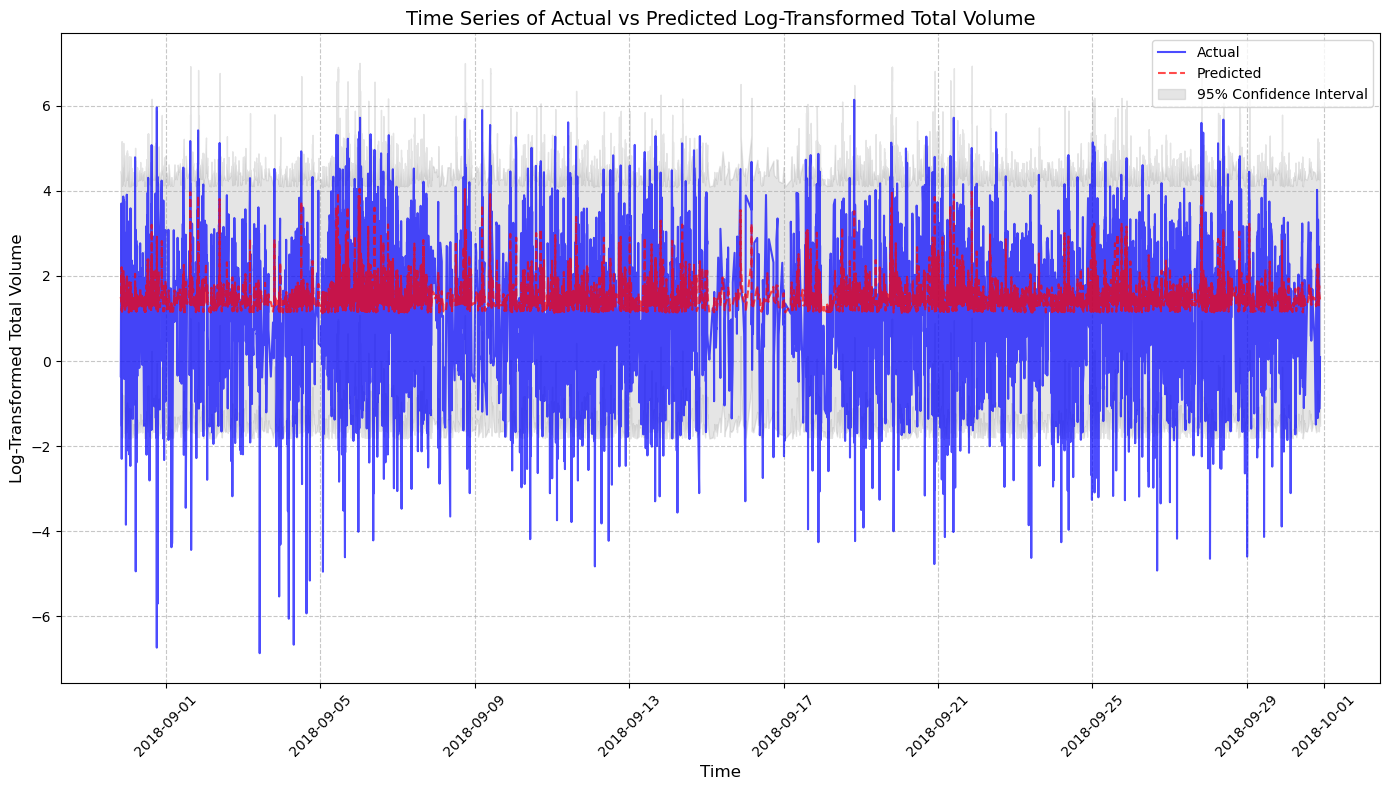

In [13]:
# Extract the timestamps for the test set
test_timestamps = merged_features['datetime_trx'].iloc[train_size + val_size:]

# Create a DataFrame for plotting
plot_df = pd.DataFrame({
    'Timestamp': test_timestamps,
    'Actual': Y_test,
    'Predicted': Y_pred
}).set_index('Timestamp').sort_index()

# Create the time series plot
plt.figure(figsize=(14, 8))
plt.plot(plot_df.index, plot_df['Actual'], label='Actual', color='blue', alpha=0.7)
plt.plot(plot_df.index, plot_df['Predicted'], label='Predicted', color='red', alpha=0.7, linestyle='--')

# Add confidence interval (using standard deviation of residuals)
residuals = Y_test - Y_pred
std_residuals = np.std(residuals)
plt.fill_between(plot_df.index, 
                 plot_df['Predicted'] - 1.96*std_residuals, 
                 plot_df['Predicted'] + 1.96*std_residuals,
                 color='gray', alpha=0.2, label='95% Confidence Interval')

plt.xlabel("Time", fontsize=12)
plt.ylabel("Log-Transformed Total Volume", fontsize=12)
plt.title("Time Series of Actual vs Predicted Log-Transformed Total Volume", fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

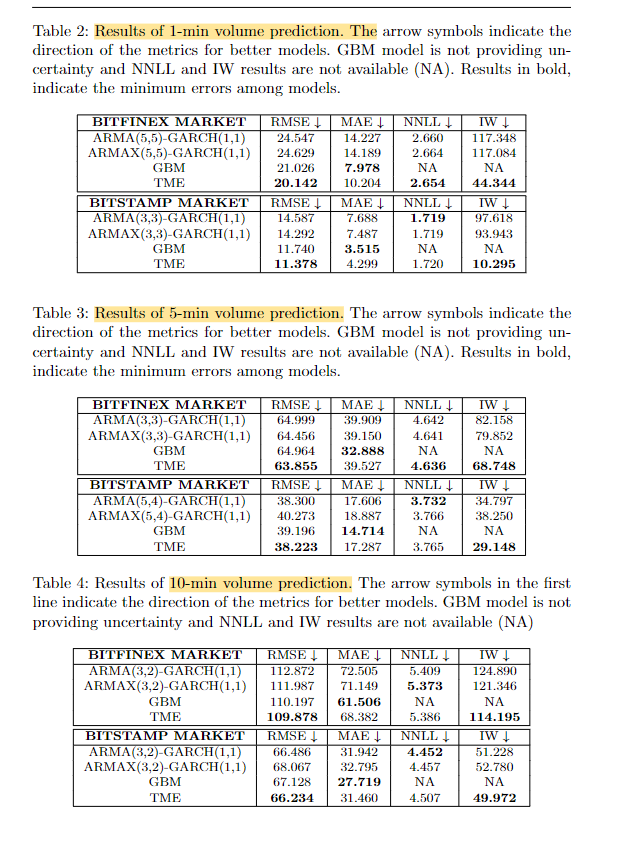